# Check out the Clay v1 model on the dataset
Adapted from https://clay-foundation.github.io/model/tutorials/clay-v1-wall-to-wall.html and https://github.com/Clay-foundation/model/blob/main/docs/tutorials/clay-v1-wall-to-wall.ipynb

In [1]:
import math

import geopandas as gpd
import numpy as np
import pandas as pd
import pystac_client
import stackstac
import torch
import yaml
from box import Box
from matplotlib import pyplot as plt
from rasterio.enums import Resampling
from shapely import Point
from torchvision.transforms import v2

import shapely
import json

from src.models.clay.model import ClayMAEModule

from src.data.get_satellite_images import ReadSTAC

In [2]:
api_url="https://planetarycomputer.microsoft.com/api/stac/v1"
# bands from B01 to B12
# bands = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']
bands = ['B02', 'B03', 'B04', 'B08']

stac_reader = ReadSTAC(api_url=api_url)

# Load Dataset

In [3]:
# load the processed dataset
tiles = gpd.read_file("data/processed/mining_tiles_with_masks_and_bounding_boxes.gpkg", layer="tiles")
masks = gpd.read_file("data/processed/mining_tiles_with_masks_and_bounding_boxes.gpkg", layer="masks")
bounding_boxes = gpd.read_file("data/processed/mining_tiles_with_masks_and_bounding_boxes.gpkg", layer="bounding_boxes")

In [4]:
# select first row
row = tiles.iloc[0]
row

tile_id                                                         621
sentinel_2_id     S2B_MSIL2A_20190517T144739_R139_T20NMP_2020100...
source_dataset                                                 tang
timestamp                                2024-06-19 09:07:50.341000
geometry          POLYGON ((-63.33333333333334 7.333333333333343...
Name: 0, dtype: object

In [18]:
# convert geojson string to shapely geometry
bounds = row.geometry.bounds
bounds

(-63.5, 7.333333333333343, -63.33333333333334, 7.5)

In [6]:
# get lat and lon
lat = row.geometry.centroid.y
lon = row.geometry.centroid.x

# Load Items and stack for the first row

In [72]:
#Intermediate solution
items = stac_reader.get_items(
    bbox=(lon - 0.01, lat - 0.01, lon + 0.01, lat + 0.01),
    timerange='2020-01-01/2020-12-30',
    max_cloud_cover=10
)
least_cloudy_item = stac_reader.filter_item(items, "least_cloudy")

3 Items found.
Found 1 unique tile ids.
Choosing the best 1 items.For unique tile 20NMP, choosing ['S2B_MSIL2A_20201008T144729_R139_T20NMP_20201010T101805'] from [datetime.date(2020, 10, 8)] with [3.265165]% cloud cover


TODO: Get this to work with get_item_by_name. 

In [73]:
# item = stac_reader.get_item_by_name(row.sentinel_2_id, bbox=bounds)
# item

In [74]:
stack = stac_reader.get_stack(
    items=least_cloudy_item, 
    bands=bands,
    crop_to_bounds=True, 
    squeeze_time_dim=False)
stack

Loading stack...
Returning stack from single S2 image with ID: S2B_MSIL2A_20201008T144729_R139_T20NMP_20201010T101805


<xarray.DataArray 'stackstac-674102a724cbd9fc086135670b650a5e' (time: 1,
                                                                band: 4,
                                                                y: 222, x: 222)> Size: 789kB
dask.array<fetch_raster_window, shape=(1, 4, 222, 222), dtype=float32, chunksize=(1, 1, 222, 222), chunktype=numpy.ndarray>
Coordinates: (12/48)
  * time                                     (time) datetime64[ns] 8B 2020-10...
    id                                       (time) <U54 216B 'S2B_MSIL2A_202...
  * band                                     (band) <U3 48B 'B02' ... 'B08'
  * x                                        (x) float64 2kB 4.529e+05 ... 4....
  * y                                        (y) float64 2kB 8.209e+05 ... 8....
    platform                                 <U11 44B 'Sentinel-2B'
    ...                                       ...
    proj:shape                               object 8B {10980}
    common_name                              (band) <U5 80B 'blue' ... 'nir'
    center_wavelength                        (band) float64 32B 0.49 ... 0.842
    full_width_half_max                      (band) float64 32B 0.098 ... 0.145
    epsg                                     int64 8B 32620
    s2_tile_id                               <U54 216B 'S2B_MSIL2A_20201008T1...
Attributes:
    spec:        RasterSpec(epsg=32620, bounds=(452910, 818720, 455130, 82094...
    crs:         epsg:32620
    transform:   | 10.00, 0.00, 452910.00|\n| 0.00,-10.00, 820940.00|\n| 0.00...
    resolution:  10
    s2_tile_id:  S2B_MSIL2A_20201008T144729_R139_T20NMP_20201010T101805

In [75]:
stack.compute()

<xarray.DataArray 'stackstac-674102a724cbd9fc086135670b650a5e' (time: 1,
                                                                band: 4,
                                                                y: 222, x: 222)> Size: 789kB
array([[[[ 775.,  720.,  693., ...,  486.,  363.,  395.],
         [ 789.,  749.,  698., ...,  527.,  338.,  353.],
         [ 743.,  721.,  718., ...,  568.,  397.,  346.],
         ...,
         [ 465.,  355.,  344., ...,  373.,  414.,  466.],
         [ 467.,  388.,  371., ...,  296.,  331.,  408.],
         [ 515.,  465.,  433., ...,  294.,  297.,  371.]],

        [[1126., 1072.,  996., ...,  771.,  548.,  611.],
         [1118., 1076., 1015., ...,  771.,  531.,  523.],
         [1058., 1028., 1016., ...,  879.,  598.,  453.],
         ...,
         [ 720.,  594.,  564., ...,  703.,  729.,  670.],
         [ 741.,  651.,  617., ...,  655.,  693.,  670.],
         [ 767.,  707.,  674., ...,  670.,  714.,  695.]],

        [[1352., 1268., 1222., ...,  799.,  601.,  608.],
         [1372., 1318., 1238., ...,  873.,  566.,  538.],
         [1284., 1262., 1214., ...,  995.,  638.,  515.],
         ...,
         [ 740.,  549.,  535., ...,  537.,  630.,  676.],
         [ 683.,  589.,  573., ...,  353.,  433.,  581.],
         [ 785.,  735.,  688., ...,  380.,  369.,  498.]],

        [[2018., 1930., 1888., ..., 2004., 1816., 1780.],
         [1980., 1964., 1932., ..., 1948., 1592., 1626.],
         [1952., 1958., 1986., ..., 2050., 1704., 1578.],
         ...,
         [2214., 2030., 1920., ..., 2868., 2554., 1976.],
         [2228., 2108., 2008., ..., 3414., 3182., 2552.],
         [2226., 2074., 1870., ..., 3244., 3526., 2990.]]]], dtype=float32)
Coordinates: (12/48)
  * time                                     (time) datetime64[ns] 8B 2020-10...
    id                                       (time) <U54 216B 'S2B_MSIL2A_202...
  * band                                     (band) <U3 48B 'B02' ... 'B08'
  * x                                        (x) float64 2kB 4.529e+05 ... 4....
  * y                                        (y) float64 2kB 8.209e+05 ... 8....
    platform                                 <U11 44B 'Sentinel-2B'
    ...                                       ...
    proj:shape                               object 8B {10980}
    common_name                              (band) <U5 80B 'blue' ... 'nir'
    center_wavelength                        (band) float64 32B 0.49 ... 0.842
    full_width_half_max                      (band) float64 32B 0.098 ... 0.145
    epsg                                     int64 8B 32620
    s2_tile_id                               <U54 216B 'S2B_MSIL2A_20201008T1...
Attributes:
    spec:        RasterSpec(epsg=32620, bounds=(452910, 818720, 455130, 82094...
    crs:         epsg:32620
    transform:   | 10.00, 0.00, 452910.00|\n| 0.00,-10.00, 820940.00|\n| 0.00...
    resolution:  10
    s2_tile_id:  S2B_MSIL2A_20201008T144729_R139_T20NMP_20201010T101805

### Load the model

We now have the data to analyse, let's load the model.

In [76]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
ckpt = "https://clay-model-ckpt.s3.amazonaws.com/v0.5.7/mae_v0.5.7_epoch-13_val-loss-0.3098.ckpt"
torch.set_default_device(device)

model = ClayMAEModule.load_from_checkpoint(
    ckpt, metadata_path="configs/metadata.yaml", shuffle=False, mask_ratio=0
)
model.eval()

model = model.to(device)

### Prepare band metadata for passing it to the model

This is the most technical part so far. We will take the information in the stack of imagery and convert it into the formate that the model requires. This includes converting the lat/lon and the date of the imagery into normalized values.

The Clay model will accept any band combination in any order, from different platforms. But for this the model needs to know the wavelength of each band that is passed to it, and normalization parameters for each band as well. It will use that to normalize the data and to interpret each band based on its central wavelength.

For Sentinel-2 we can use medata file of the model to extract those values. But this cloud also be something custom for a different platform.

In [77]:
# Extract mean, std, and wavelengths from metadata
platform = "sentinel-2-l2a"
metadata = Box(yaml.safe_load(open("configs/metadata.yaml")))
mean = []
std = []
waves = []
# Use the band names to get the correct values in the correct order.
for band in stack.band:
    mean.append(metadata[platform].bands.mean[str(band.values)])
    std.append(metadata[platform].bands.std[str(band.values)])
    waves.append(metadata[platform].bands.wavelength[str(band.values)])

# Prepare the normalization transform function using the mean and std values.
transform = v2.Compose(
    [
        v2.Normalize(mean=mean, std=std),
    ]
)

### Convert the band pixel data in to the format for the model

We will take the information in the stack of imagery and convert it into the formate that the model requires. This includes converting the lat/lon and the date of the imagery into normalized values.

In [78]:
# Prep datetimes embedding using a normalization function from the model code.
def normalize_timestamp(date):
    week = date.isocalendar().week * 2 * np.pi / 52
    hour = date.hour * 2 * np.pi / 24

    return (math.sin(week), math.cos(week)), (math.sin(hour), math.cos(hour))


datetimes = [stack["s2:generation_time"].values.astype("datetime64[s]").tolist()]
times = [normalize_timestamp(dat) for dat in datetimes]
week_norm = [dat[0] for dat in times]
hour_norm = [dat[1] for dat in times]


# Prep lat/lon embedding using the
def normalize_latlon(lat, lon):
    lat = lat * np.pi / 180
    lon = lon * np.pi / 180

    return (math.sin(lat), math.cos(lat)), (math.sin(lon), math.cos(lon))


latlons = [normalize_latlon(lat, lon)] * len(times)
lat_norm = [dat[0] for dat in latlons]
lon_norm = [dat[1] for dat in latlons]

# Normalize pixels
pixels = torch.from_numpy(stack.data.astype(np.float32).compute())
pixels = transform(pixels)

### Combine the metadata and the transformed pixels

Now we can combine all of these inputs into a dictionary that combines everything.

In [79]:
# Prepare additional information
datacube = {
    "platform": platform,
    "time": torch.tensor(
        np.hstack((week_norm, hour_norm)),
        dtype=torch.float32,
        device=device,
    ),
    "latlon": torch.tensor(
        np.hstack((lat_norm, lon_norm)), dtype=torch.float32, device=device
    ),
    "pixels": pixels.to(device),
    "gsd": torch.tensor(stack.gsd.values, device=device),
    "waves": torch.tensor(waves, device=device),
}

### Run the model

Pass the datacube we prepared to the model to create embeddings. This will create one embedding vector for each of the images we downloaded.

In [80]:
with torch.no_grad():
    unmsk_patch, unmsk_idx, msk_idx, msk_matrix = model.model.encoder(datacube)

# The first embedding is the class token, which is the
# overall single embedding.
embeddings = unmsk_patch[:, 0, :].cpu().numpy()
embeddings.shape

In [82]:
print(unmsk_patch.shape)
embeddings.shape

torch.Size([1, 730, 768])


(1, 768)

(730, 768)


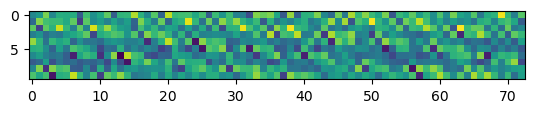

In [102]:
# reshape to 2D array by removing the first dimension
unmsk_patch_2d = unmsk_patch.squeeze(0).cpu().numpy()
print(unmsk_patch_2d.shape)

# reshape into original size per dimension
first_dim = unmsk_patch_2d[:,1]

# reshape into size of 27x27
first_dim = np.reshape(first_dim, (10,-1))

# plot the unmsk_patch_2d
plt.imshow(first_dim)